In [105]:
import numpy as np
from scipy import sparse
import pandas as pd
from copy import copy
from sklearn.metrics.pairwise import pairwise_distances
import time
import matplotlib.pyplot as plt                                # plotting
%matplotlib inline

#### Read data

In [2]:
wiki = pd.DataFrame.from_csv('people_wiki.csv')

In [3]:
wiki = wiki.reset_index()

In [4]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return sparse.csr_matrix( (data, indices, indptr), shape)
    
corpus = load_sparse_csr('people_wiki_tf_idf.npz')

In [5]:
map_index_to_word = pd.read_json('people_wiki_map_index_to_word.json', typ='series', orient='records')

#### Generate a collection of random vectors

In [6]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)

Generate 3 random vectors of dimension 5, arranged into a single 5 x 3 matrix

In [7]:
np.random.seed(0)
print(generate_random_vectors(3, 5))

[[ 1.76405235  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]
 [ 0.76103773  0.12167502  0.44386323]]


Generate 16 random vectors of dimension 547979, the same dimensionality as our vocubulary size (547979)

In [8]:
np.random.seed(0)
random_vectors = generate_random_vectors(16, 547979)
print(random_vectors.shape)

(547979, 16)


#### Partition data points into bins

Check if doc 0 belongs to bin 1

In [9]:
doc = corpus[0, :]
print((doc.dot(random_vectors[:, 0])) >= 0)

[ True]


Check if doc 1 belongs to bin 2

In [10]:
print((doc.dot(random_vectors[:, 1])) >= 0)

[ True]


In [11]:
print(doc.dot(random_vectors) >= 0)

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]


In [12]:
print(np.array(doc.dot(random_vectors) >= 0, dtype=int))

[[1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1]]


All documents that obtain exactly this vector will be assigned to the same bin.

In [13]:
print(corpus[0:2].dot(random_vectors) >= 0) # compute bit indices of first two documents
print(corpus.dot(random_vectors) >= 0) # compute bit indices of ALL documents

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]
 [ True False False False  True  True False  True  True False  True False
   True False False  True]]
[[ True  True False ...,  True False  True]
 [ True False False ..., False False  True]
 [False  True False ...,  True False  True]
 ..., 
 [ True  True False ...,  True  True  True]
 [False  True  True ...,  True False  True]
 [ True False  True ..., False False  True]]


To make it convenient to refer to individual bins, we convert each binary bin index into a single integer:<br>
For example:<br>
[0,0,0,0,0,0,0,0,0,0,0,0]   => 0<br>
[0,0,0,0,0,0,0,0,0,0,0,1]   => 1<br>
[1,1,1,1,1,1,1,1,1,1,1,1]   => 65535 (= 2^16-1)<br>

To do that, we just need to compute the dot product between the document vector and the vector consisting of powers of 2

In [14]:
doc = corpus[0, :]
index_bits = (doc.dot(random_vectors) >= 0)
power_of_two = (1 << np.arange(15, -1, -1))
print(index_bits.dot(power_of_two))

[50917]


In [15]:
index_bits = corpus.dot(random_vectors) > 0
print(index_bits.dot(power_of_two))

[50917 36265 19365 ..., 52983 27589 41449]


In [16]:
def train_lsh(data, num_vector=16, seed=None):
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
    
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    table = {}
    
    bin_index_bits = (data.dot(random_vectors) >= 0)
    
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    for data_index, bin_index in enumerate(bin_indices):
        table.setdefault(bin_index, []).append(data_index)
        
    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vectors': num_vector}
    
    return model

In [17]:
model = train_lsh(corpus, num_vector=16, seed=143)

Check

In [18]:
table = model['table']
if 0 in table and table[0] == [39583] and 143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print('Passed!')
else:
    print('Check your code.')

Passed!


#### OK! Now we have the model, let's rock

In [19]:
print(wiki[wiki['name'] == 'Barack Obama'])

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text  
35817  barack hussein obama ii brk husen bm born augu...  


##### Quiz Question. What is the document id of Barack Obama's article?<br>

35817

##### Quiz Question. Which bin contains Barack Obama's article? Enter its integer index.

In [20]:
print(model['bin_indices'][35817])

50194


##### Quiz Question. Examine the bit representations of the bins containing Barack Obama and Joe Biden. In how many places do they agree?

In [21]:
row_number = wiki[wiki['name'] == 'Joe Biden'].index.values

In [22]:
model['bin_index_bits'][row_number] == model['bin_index_bits'][35817]

array([[ True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True]], dtype=bool)

Compare the result with a former British diplomat

In [23]:
print(wiki[wiki['name']=='Wynn Normington Hugh-Jones'])

print(np.array(model['bin_index_bits'][22745], dtype=int)) # list of 0/1's
print(model['bin_index_bits'][35817] == model['bin_index_bits'][22745])

                                                     URI  \
22745  <http://dbpedia.org/resource/Wynn_Normington_H...   

                             name  \
22745  Wynn Normington Hugh-Jones   

                                                    text  
22745  sir wynn normington hughjones kb sometimes kno...  
[0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0]
[False False  True False  True False False  True  True  True False  True
  True False False  True]


Let's look at which documents are in the same bin as the Barack Obama article.

In [24]:
print(model['table'][model['bin_indices'][35817]])

[21426, 35817, 39426, 50261, 53937]


In [25]:
doc_ids = model['table'][model['bin_indices'][35817]].copy()
doc_ids.remove(35817)

docs = wiki.loc[doc_ids]

Measure similarity

In [26]:
from sklearn import preprocessing

In [27]:
def norm(x):
    sum_sq=x.dot(x.T)
    norm=np.sqrt(sum_sq)
    return(norm)

def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x) * norm(y))
    return 1-dist[0, 0]

obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

print('================= Cosine distance from Barack Obama')
print('Barack Obama - {0:24s}: {1:f}'.format('Joe Biden', cosine_distance(obama_tf_idf, biden_tf_idf)))
for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id,:]
    print('Barack Obama - {0:24s}: {1:f}'.format(wiki.loc[doc_id]['name'],
                                                 cosine_distance(obama_tf_idf, doc_tf_idf)))

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.703139
Barack Obama - Mark Boulware           : 0.950867
Barack Obama - John Wells (politician) : 0.975966
Barack Obama - Francis Longstaff       : 0.978256
Barack Obama - Madurai T. Srinivasan   : 0.993092


#### Query the LSH Model

One document can be described as a list of bool variables, then we search it's nearby by flipping one boolean, for example<br>

document i can be described as [T, T, T, F, F]<br>
we flip one boolean to get [F, T, T, F, F]

In [50]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = not alternate_bits[i]
        
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        if nearby_bin in table:
            candidate_set.update(table[nearby_bin])
    
    return candidate_set

Checkpoint

In [53]:
obama_bin_index = model['bin_index_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print('Passed test')
else:
    print('Check your code')
print('List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261')

Passed test
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261


In [54]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print('Passed test')
else:
    print('Check your code')

Passed test


In [93]:
def query(vec, model, k, max_search_radius):
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    candidate_set = set()
    for search_radius in range(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
        
    nearest_neighbors = pd.DataFrame({'id': list(candidate_set)})
    candidates = data[np.array(list(candidate_set)), :]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.nsmallest(k, 'distance'), len(candidate_set)

In [94]:
result, num_candidates_considered = query(corpus[35817,:], model, k=10, max_search_radius=3)

In [95]:
wiki['id'] = wiki.index

In [96]:
pd.merge(result, wiki, on='id', how='left')

,id,distance,URI,name,text
0,35817,-6.661338e-16,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...
1,24478,7.031387e-01,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...
2,56008,8.568481e-01,<http://dbpedia.org/resource/Nathan_Cullen>,Nathan Cullen,nathan cullen mp born july 13 1972 is a canadi...
3,37199,8.746687e-01,<http://dbpedia.org/resource/Barry_Sullivan_(l...,Barry Sullivan (lawyer),barry sullivan is a chicago lawyer and as of j...
4,40353,8.900342e-01,<http://dbpedia.org/resource/Neil_MacBride>,Neil MacBride,neil h macbride born 1965 was the united state...
5,9267,8.983772e-01,<http://dbpedia.org/resource/Vikramaditya_Khanna>,Vikramaditya Khanna,vikramaditya khanna is a professor of law at t...
6,55909,8.993404e-01,<http://dbpedia.org/resource/Herman_Cain>,Herman Cain,herman cain born december 13 1945 is an americ...
7,9165,9.009210e-01,<http://dbpedia.org/resource/Raymond_F._Cleven...,Raymond F. Clevenger,raymond francis clevenger born june 6 1926 was...
8,57958,9.030033e-01,<http://dbpedia.org/resource/Michael_J._Malbin>,Michael J. Malbin,michael j malbin is the executive director of ...
9,49872,9.095328e-01,<http://dbpedia.org/resource/Lowell_Barron>,Lowell Barron,lowell ray barron is a former democratic polit...


Test the query!

In [103]:
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in range(17):
    start=time.time()
    # Perform LSH query using Barack Obama, with max_search_radius
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start  # Measure time
    
    print('Radius:', max_search_radius)
    # Display 10 nearest neighbors, along with document ID and name
    pd.merge(result, wiki, on='id', how='left').sort_values('distance')
    
    # Collect statistics on 10 nearest neighbors
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
Radius: 1
Radius: 2
Radius: 3
Radius: 4
Radius: 5
Radius: 6
Radius: 7
Radius: 8
Radius: 9
Radius: 10
Radius: 11
Radius: 12
Radius: 13
Radius: 14
Radius: 15
Radius: 16


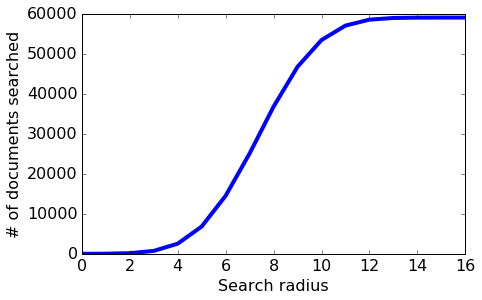

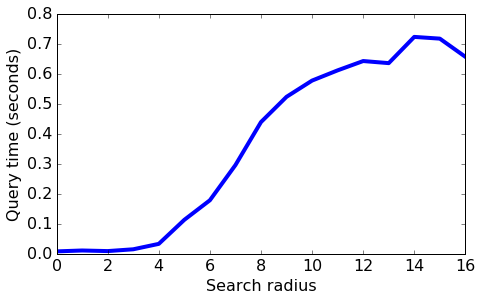

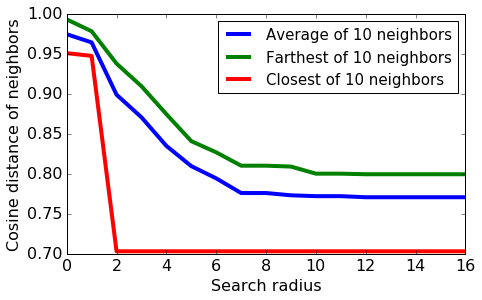

In [106]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

##### Quiz Question. What was the smallest search radius that yielded the correct nearest neighbor, namely Joe Biden?

2

##### Quiz Question. Suppose our goal was to produce 10 approximate nearest neighbors whose average distance from the query document is within 0.01 of the average for the true 10 nearest neighbors. For Barack Obama, the true 10 nearest neighbors are on average about 0.77. What was the smallest search radius for Barack Obama that produced an average distance of 0.78 or better?

In [110]:
np.where(np.array(average_distance_from_query_history) <= 0.78)

(array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16], dtype=int64),)

7